In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,eng_macd,macd_diff_12_26_9,body_pct,macd_line_12_26_9,volume,obv_diff_14,eng_rsi,eng_atr_div,eng_adx,adx_14,hour,body,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,6.967909e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,7.448270e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,7.961747e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,8.510623e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,9.097338e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.634772,0.888941,0.624850,0.971125,0.362651,1.000000,0.0,0.664288,0.537709,0.301944,-0.975989,0.854984,196.815000,1.654708e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.633511,0.840741,0.374057,0.981544,0.434283,0.000000,0.0,0.676887,0.541855,0.328685,-0.975989,0.158091,196.675000,1.484384e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.631866,0.777896,0.494766,0.983006,0.496049,0.000000,0.0,0.584662,0.545337,0.353515,-0.975989,0.493632,196.670000,1.477119e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.623450,0.456523,0.090577,0.884486,1.000000,0.000000,0.0,0.645760,0.531521,0.348960,-0.975989,0.000000,196.240000,1.166764e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'eng_macd', 'macd_diff_12_26_9', 'body_pct', 'macd_line_12_26_9', 'volume', 'obv_diff_14', 'eng_rsi', 'eng_atr_div', 'eng_adx', 'adx_14', 'hour', 'body']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3792  (2004-01-02 → 2019-01-25)
 windows       : 1823952  (per-day min=481, max=481, mean=481.0)
 window shape  : look_back=90, n_features=20
 dataloader    : batches=237, batch_size=16, workers=12, pin_memory=True

--- VAL ---
 calendar days : 799  (2019-01-28 → 2022-03-28)
 windows       : 384319  (per-day min=481, max=481, mean=481.0)
 window shape  : look_back=90, n_features=20
 dataloader    : batches=799, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 389129  (per-day min=481, max=481, mean=481.0)
 window shape  : look_back=90, n_features=20
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# importlib.reload(params.model_selected) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats          = len(params.features_cols_tick),                          
    short_units      = params.hparams['SHORT_UNITS'],    
    long_units       = params.hparams['LONG_UNITS'],     
    dropout_short    = params.hparams['DROPOUT_SHORT'],  
    dropout_long     = params.hparams['DROPOUT_LONG'],   
    conv_k           = params.hparams['CONV_K'],
    conv_dilation    = params.hparams['CONV_DILATION'],
    # smooth_k         = params.hparams['SMOOTH_K'],
    # smooth_dilation  = params.hparams['SMOOTH_DILATION']
    pred_hidden      = params.hparams['PRED_HIDDEN'],
)
model.to(params.device)  

model

ModelClass(
  (conv): Conv1d(20, 20, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(20, 96, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.2, inplace=False)
  (short2long): Linear(in_features=192, out_features=256, bias=True)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (pred): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [6]:
# # model check: overfit one batch: force your model to train on the exact same small set of examples over and over.
# # You should see loss → 0 in a few dozen steps on a single batch.

# # 1) Grab a single batch (no shuffle issues)
# batch = next(iter(train_loader))
# x_pad, y_sig, *_, lengths = batch

# # 2) Move to device
# device = next(model.parameters()).device
# x_pad = x_pad.to(device)
# y_sig = y_sig.to(device)

# # 3) Extract just the first day’s valid windows
# #    lengths[0] might be a tensor or int
# W = lengths[0].item() if isinstance(lengths[0], torch.Tensor) else lengths[0]
# x_day = x_pad[0, :W]       # shape (W, features…)
# y_day = y_sig[0, :W]       # shape (W,)

# # 4) Our single target is the last tick of that day
# target_val = y_day[-1].unsqueeze(0)   # shape (1,)

# # 5) Turn off dropout so we can memorize perfectly
# for m in model.modules():
#     if isinstance(m, Dropout):
#         m.p = 0.0

# # 6) Clear any saved LSTM state (if your model uses h_short/h_long)
# if hasattr(model, "h_short"): model.h_short = None
# if hasattr(model, "h_long"):  model.h_long  = None

# # 7) Set up optimizer & loss
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
# criterion = MSELoss()

# # 8) Overfit loop: reset state every pass, predict last‐tick, compare scalar→scalar
# model.train()
# for step in range(100):
#     optimizer.zero_grad()

#     # reset hidden state each iteration
#     if hasattr(model, "h_short"): model.h_short = None
#     if hasattr(model, "h_long"):  model.h_long  = None

#     # forward on the full day sequence
#     raw_out = model(x_day)  
#     raw_reg = raw_out[0] if isinstance(raw_out, (tuple, list)) else raw_out

#     # collapse to shape (W,)
#     if raw_reg.dim() == 3:
#         raw_reg = raw_reg[0].squeeze(-1)
#     elif raw_reg.dim() == 2:
#         raw_reg = raw_reg.squeeze(-1)

#     # take *only* the final-tick prediction → scalar
#     pred_val = raw_reg[-1].unsqueeze(0)   # shape (1,)

#     # compute scalar loss
#     loss = criterion(pred_val, target_val)
#     loss.backward()
#     optimizer.step()

#     if (step + 1) % 10 == 0 or step == 0:
#         print(f"Step {step+1:02d}  loss={loss.item():.6f}")


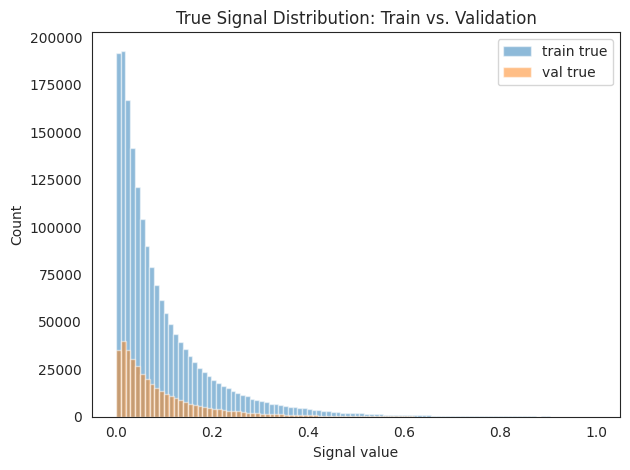

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3792 unique trading days per epoch.

Using HyperParameters:
 "look_back": 90 {'CONV_K': 5, 'CONV_DILATION': 2, 'ALPHA_SMOOTH': 10, 'SHORT_UNITS': 192, 'LONG_UNITS': 256, 'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.2, 'PRED_HIDDEN': 128, 'MAX_EPOCHS': 50, 'EARLY_STOP_PATIENCE': 5, 'WEIGHT_DECAY': 0.0002, 'CLIPNORM': 1, 'ONECYCLE_MAX_LR': 0.0002, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 1000, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'NUM_WORKERS': 12, 'TRAIN_PREFETCH_FACTOR': 4}


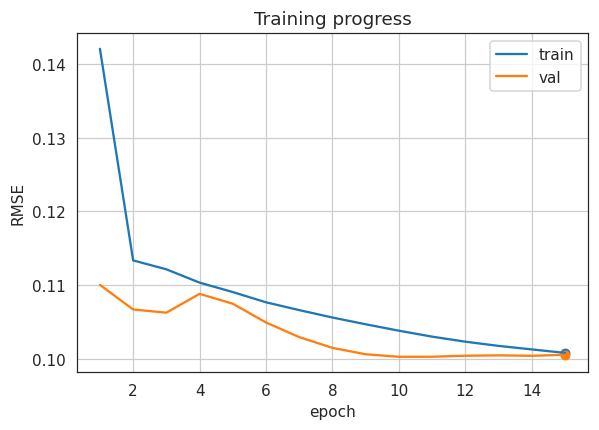

Epoch 1 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 01  TRAIN → RMSE=0.14207, R²=-0.553 |  VALID → RMSE=0.11005, R²=-0.040 |  lr=3.72e-05


Epoch 2 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 02  TRAIN → RMSE=0.11336, R²=0.011 |  VALID → RMSE=0.10670, R²=0.022 |  lr=8.23e-05


Epoch 3 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 03  TRAIN → RMSE=0.11215, R²=0.032 |  VALID → RMSE=0.10627, R²=0.030 |  lr=1.38e-04


Epoch 4 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 04  TRAIN → RMSE=0.11035, R²=0.063 |  VALID → RMSE=0.10882, R²=-0.017 |  lr=1.83e-04


Epoch 5 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 05  TRAIN → RMSE=0.10907, R²=0.085 |  VALID → RMSE=0.10749, R²=0.008 |  lr=2.00e-04


Epoch 6 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 06  TRAIN → RMSE=0.10768, R²=0.108 |  VALID → RMSE=0.10494, R²=0.054 |  lr=2.00e-04


Epoch 7 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 07  TRAIN → RMSE=0.10662, R²=0.125 |  VALID → RMSE=0.10296, R²=0.090 |  lr=1.99e-04


Epoch 8 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 08  TRAIN → RMSE=0.10561, R²=0.142 |  VALID → RMSE=0.10150, R²=0.115 |  lr=1.98e-04


Epoch 9 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 09  TRAIN → RMSE=0.10470, R²=0.157 |  VALID → RMSE=0.10063, R²=0.130 |  lr=1.96e-04


Epoch 10 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 10  TRAIN → RMSE=0.10383, R²=0.171 |  VALID → RMSE=0.10029, R²=0.136 |  lr=1.94e-04


Epoch 11 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 11  TRAIN → RMSE=0.10302, R²=0.183 |  VALID → RMSE=0.10029, R²=0.136 |  lr=1.91e-04


Epoch 12 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 12  TRAIN → RMSE=0.10234, R²=0.194 |  VALID → RMSE=0.10043, R²=0.134 |  lr=1.88e-04


Epoch 13 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 13  TRAIN → RMSE=0.10177, R²=0.203 |  VALID → RMSE=0.10048, R²=0.133 |  lr=1.85e-04


Epoch 14 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 14  TRAIN → RMSE=0.10129, R²=0.211 |  VALID → RMSE=0.10043, R²=0.134 |  lr=1.81e-04


Epoch 15 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 15  TRAIN → RMSE=0.10082, R²=0.218 |  VALID → RMSE=0.10056, R²=0.131 |  lr=1.77e-04
Early stopping at epoch 15
✅ Final‐best model saved: AAPL_0.10029_fin.pth


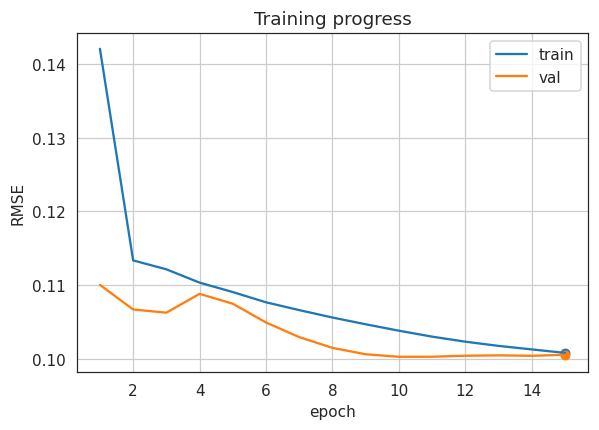

In [8]:
importlib.reload(params) #############
importlib.reload(params.model_selected) #############
importlib.reload(models_core) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)


optimizer = AdamW(
    model.parameters(),
    lr = params.hparams["ONECYCLE_MAX_LR"],      
    weight_decay = params.hparams["WEIGHT_DECAY"]
)

total_steps = len(train_loader) * params.hparams["MAX_EPOCHS"] # batches × epochs

scheduler = OneCycleLR(
    optimizer,
    max_lr              = params.hparams["ONECYCLE_MAX_LR"],
    total_steps         = total_steps,
    pct_start           = params.hparams["ONECYCLE_PCT_START"],
    div_factor          = params.hparams["ONECYCLE_DIV_FACTOR"],
    final_div_factor    = params.hparams["ONECYCLE_FINAL_DIV"],
    anneal_strategy     = params.hparams["ONECYCLE_STRATEGY"]
)


# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = params.hparams['CLIPNORM'],
    alpha_smooth        = params.hparams['ALPHA_SMOOTH']
)
